In [1]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression


In [2]:
# 2. Đọc file dữ liệu chứng khoán AAPL và chia train test validate theo tỉ lệ 7:1:2
df = pd.read_csv('EBAY.csv')
df = df[['Close']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [3]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.0 MB/s eta 0:00:00


In [4]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2226.012, Time=3.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2218.185, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2220.055, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2220.054, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2217.470, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2222.042, Time=0.34 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 4.166 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [16]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))

history = y_train[-1]
# chuyển đổi mảng numpy thành đối tượng Series
y_train_series = pd.Series(y_train)

# tính độ lệch chuẩn của phân phối nhiễu trắng
std_test = y_train_series.diff().dropna().std()
random_walk_pred_test = []

for i in range(len(y_test)):
    yhat = history + np.random.normal(scale=std_test)
    random_walk_pred_test.append(yhat)
    obs = y_test[i]
    history = obs

hybrid_pred_test = np.multiply(0.1, y_pred) + np.multiply(0.9, random_walk_pred_test)
print(hybrid_pred_test.shape)

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(n_periods=len(y_val))
history = y_test[-1]
# chuyển đổi mảng numpy thành đối tượng Series
y_test_series = pd.Series(y_test)

# tính độ lệch chuẩn của phân phối nhiễu trắng
std_val = y_test_series.diff().dropna().std()
random_walk_pred_val = []

for i in range(len(y_val)):
    yhat = history + np.random.normal(scale=std_val)
    random_walk_pred_val.append(yhat)
    obs = y_val[i]
    history = obs

hybrid_pred_val = np.multiply(0.1, y_pred_val) + np.multiply(0.9, random_walk_pred_val)
print(hybrid_pred_val)

(222,)
[42.82243124 42.03818148 42.99120446 42.37537804 41.36585099 40.31686561
 40.81459344 43.32054394 42.75513414 45.5209079  44.40631526 45.67211064
 45.75385422 45.358942   45.13803891 47.86982859 46.94822688 48.37705939
 49.03326876 46.82388016 45.15272628 46.55700611 47.99194131 47.39597335
 52.48490073 48.14922262 48.42261082 50.35190753 49.71976713 52.08122956
 50.35900471 51.1708389  50.27914606 50.31679062 50.18050983 49.71059348
 49.69730956 49.49600708 49.26900058 48.88752107 49.11139588 49.21732094
 49.76279685 48.75210708 46.22872254 43.71313    46.5443055  46.56430069
 46.54132294 46.75821193 46.13251934 46.06861774 43.73898894 46.32611911
 43.69237596 43.39973529 43.66636889 43.13309104 41.92638035 44.04468451
 43.67291032 43.51186724 46.54776136 42.39271861 42.86790067 43.98735221
 45.12607301 45.34598399 44.40173479 46.46526675 46.02871819 45.71590118
 43.59619132 45.92658794 45.1548227  45.24202942 43.90898919 43.59657967
 45.6406248  45.84499507 44.3660243  45.6714

In [17]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

history = y_val[-1]
# chuyển đổi mảng numpy thành đối tượng Series
y_val_series = pd.Series(y_val)

# tính độ lệch chuẩn của phân phối nhiễu trắng
std_next_30s = y_val_series.diff().dropna().std()
random_walk_pred_next = []

for i in range(len(y_next_30_days)):
    yhat = history + np.random.normal(scale=std_next_30s)
    random_walk_pred_next.append(yhat)
    obs = y_next_30_days[i]
    history = obs

hybrid_pred_next = np.multiply(0.1, y_next_30_days) + np.multiply(0.9, random_walk_pred_next)
print('Predicted closing prices for the next 30 days:')
print(hybrid_pred_next)

Predicted closing prices for the next 30 days:
[43.31771724 57.80166512 58.67030436 56.61368358 58.65735138 59.80288482
 59.9274129  60.30059815 59.61149951 59.87082659 57.73964141 59.02351527
 59.07198621 58.35390524 58.3249417  59.51404281 58.35557538 58.90442596
 58.81804951 58.47387041 58.92727356 58.39666012 58.79331581 58.80146947
 58.89031318 58.95482134 59.75934016 58.41859705 59.31655631 58.73608285]


In [18]:
# 7. Đánh giá độ chính xác validate, test
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
valid_rw_rmse = np.sqrt(np.mean((hybrid_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_rw_rmse = np.sqrt(np.mean((hybrid_pred_test - y_test)**2))
print('Validation RMSE:', valid_rw_rmse)
print('Testing RMSE:', test_rw_rmse)


Validation RMSE: 1.9080045638115057
Testing RMSE: 1.926419275185175


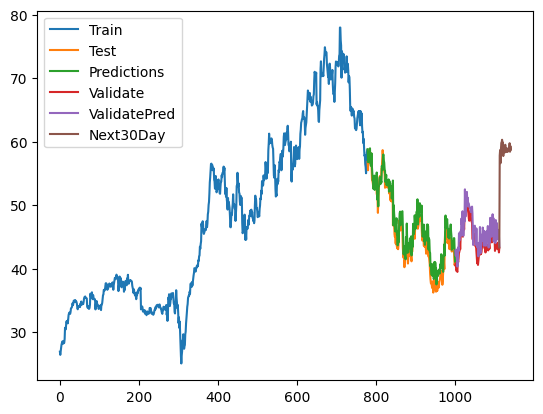

In [20]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, hybrid_pred_test)
plt.plot(val_data.index, val_data['Close'])
plt.plot(val_data.index, hybrid_pred_val)
plt.plot(last_data,hybrid_pred_next)
plt.legend(['Train', 'Test', 'Predictions','Validate','ValidatePred','Next30Day'])
plt.show()

In [9]:
test_data.index

RangeIndex(start=778, stop=1000, step=1)